In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import time
import datetime
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

Loading the Dataset

In [ ]:
df = pd.read_csv('loan_train.csv')
df = df.iloc[1: , 2:]
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
5,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male


In [ ]:
print(df.dtypes)

loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object


Data Mapping and Converting Dates to Timestamps

In [ ]:
encoder=preprocessing.LabelEncoder()
df['loan_status'] = encoder.fit_transform(df['loan_status'])
df['education'] = encoder.fit_transform(df['education'])
df['Gender'] = encoder.fit_transform(df['Gender'])

df['due_date'] = pd.to_datetime(df['due_date'], format='%m/%d/%Y')
for i in range(1,len(df['due_date'])+1):
    element = datetime.datetime.strptime(df['due_date'][i].strftime("%d/%m/%Y"),"%d/%m/%Y")
    df['due_date'][i] = int(datetime.datetime.timestamp(element))

df['effective_date'] = pd.to_datetime(df['effective_date'], format='%m/%d/%Y')
for i in range(1,len(df['effective_date'])+1):
    element = datetime.datetime.strptime(df['effective_date'][i].strftime("%d/%m/%Y"),"%d/%m/%Y")
    df['effective_date'][i] = int(datetime.datetime.timestamp(element))
df.head()

<ipython-input-65-08df844b8043>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['due_date'][i] = int(datetime.datetime.timestamp(element))
<ipython-input-65-08df844b8043>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['effective_date'][i] = int(datetime.datetime.timestamp(element))


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
1,1,1000,30,1473292800,1475798400,33,0,0
2,1,1000,15,1473292800,1474502400,27,3,1
3,1,1000,30,1473379200,1475884800,28,3,0
4,1,1000,30,1473379200,1475884800,29,3,1
5,1,1000,30,1473379200,1475884800,36,3,1


making the dataframe an int dataframe

In [ ]:
df = df.astype(int)

Getting rid of rows that contains outliers to improve model accuracy

In [ ]:
#Calculate the mean and standard deviation for each column
column_means = np.mean(df, axis=0)
column_std_devs = np.std(df, axis=0)

#Calculate the z-score for each cell based on its column
z_scores = (df - column_means) / column_std_devs

#Define a threshold for outliers (e.g., ±3 standard deviations)
threshold = 3

#Identify outliers
outliers = np.abs(z_scores) > threshold

#Remove rows containing outliers
df = df[~np.any(outliers, axis=1)]

#Print the z-scores and cleaned data
print("Z-scores:")
print(z_scores)
print("\nCleaned data (rows with outliers removed):")
print(df)

Z-scores:
     loan_status  Principal     terms  effective_date  due_date       age  \
1       0.576235   0.516731  0.923186       -3.063716  0.203773  0.350730   
2       0.576235   0.516731 -0.956235       -3.063716 -1.204136 -0.650664   
3       0.576235   0.516731  0.923186       -2.184363  0.297633 -0.483765   
4       0.576235   0.516731  0.923186       -2.184363  0.297633 -0.316866   
5       0.576235   0.516731  0.923186       -2.184363  0.297633  0.851427   
..           ...        ...       ...             ...       ...       ...   
341    -1.735404  -1.311701 -0.956235       -0.425658 -0.922554  0.183831   
342    -1.735404   0.516731  0.923186       -0.425658  0.485354 -0.984462   
343    -1.735404  -1.311701 -0.956235        0.453695 -0.828694  1.352124   
344    -1.735404   0.516731  0.923186        0.453695  3.395032 -0.483765   
345    -1.735404   0.516731  0.923186        0.453695  0.579215 -0.817563   

     education    Gender  
1    -1.521865 -2.373734  
2     1.098

Correlation Matrix

<Axes: >

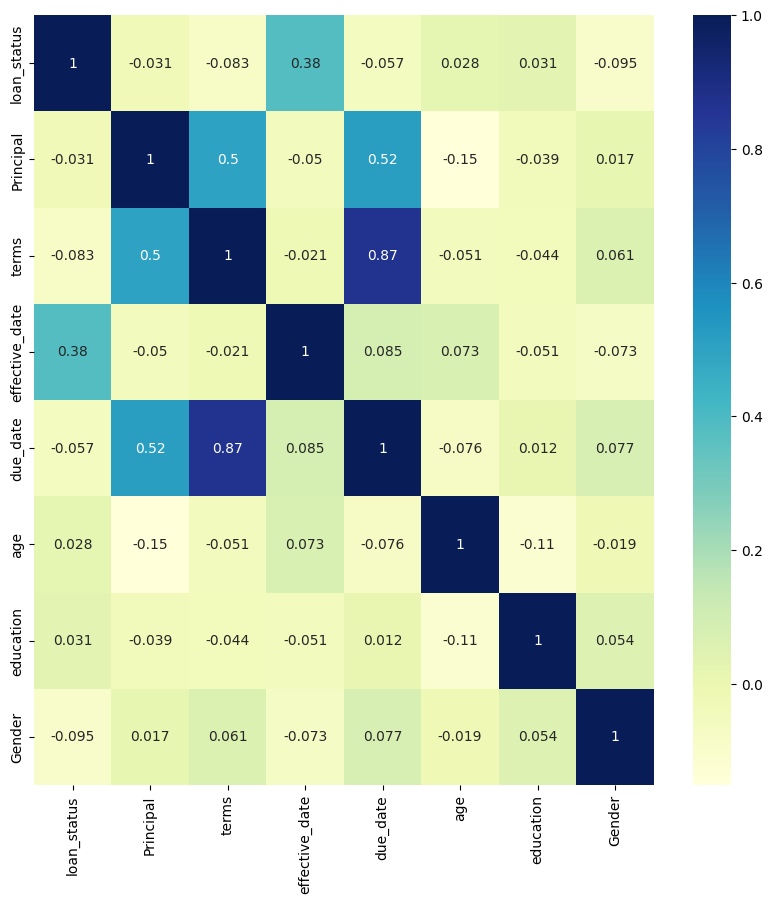

In [ ]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr(), annot=True,cmap='YlGnBu')

Split to Features and Output Labels

In [ ]:
X = df.iloc[:,1:]
Y = df.iloc[:,0]
X

,Principal,terms,effective_date,due_date,age,education,Gender
3,1000,30,1473379200,1475884800,28,3,0
4,1000,30,1473379200,1475884800,29,3,1
5,1000,30,1473379200,1475884800,36,3,1
6,1000,30,1473379200,1475884800,28,3,1
7,800,15,1473465600,1474675200,26,3,1
...,...,...,...,...,...,...,...
339,1000,30,1473552000,1476057600,29,3,0
341,800,15,1473552000,1474761600,32,1,1
342,1000,30,1473552000,1476057600,25,1,1
343,800,15,1473638400,1474848000,39,3,1


Split to Training set and Testing set

In [ ]:
col=X.columns
object = StandardScaler()
X = object.fit_transform(X)
X=pd.DataFrame(X,columns=col)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

replace Nan values with mean value of the column

In [ ]:
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.fit_transform(x_test)

Trying different Hyperparameter K and choosing K which gives the best accuracy

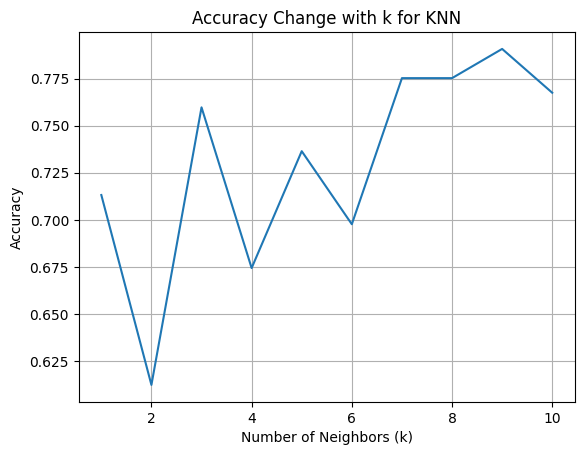

In [ ]:
# Define hyperparameters and evaluation metric
hyperparameter_grid = {'n_neighbors': range(1, 11)}  # Explore k from 1 to 10
evaluation_metric = 'accuracy'
# Create an empty list to store evaluation metrics (accuracy for each k)
k_values = []
accuracy_scores = []

# Loop through k values in hyperparameter grid
for k in hyperparameter_grid['n_neighbors']:
    # Create a KNN model with current k value
    knn = KNeighborsClassifier(n_neighbors=k)

    # Train the model
    knn.fit(x_train, y_train)

    # Make predictions on testing set
    y_pred = knn.predict(x_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append k and accuracy to respective lists
    k_values.append(k)
    accuracy_scores.append(accuracy)

# Create the line chart
plt.plot(k_values, accuracy_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy Change with k for KNN')
plt.grid(True)
plt.show()


Choose the best metric to measure distance

In [ ]:

def evaluate_metric(metric):
  knn.metric = metric
  accuracy = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy').mean()
  return accuracy, metric

metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']

knn = KNeighborsClassifier(n_neighbors=9)  # Adjust n_neighbors as needed

results = []
for metric in metrics:
  accuracy, metric_name = evaluate_metric(metric)
  results.append((accuracy, metric_name))

results.sort(reverse=True)
best_metric, best_accuracy = results[0]

print("Best Metric:", best_metric)
print("Best Accuracy:", best_accuracy)

knn.metric = best_accuracy
knn.fit(x_train, y_train)


Best Metric: 0.6736842105263158
Best Accuracy: chebyshev


KNeighborsClassifier(metric='chebyshev', n_neighbors=9)

Train model using the best K and metric

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9,metric = 'chebyshev')
knn = knn.fit(x_train,y_train)

Training Accuracy

In [ ]:
y_pred =knn.predict(x_test)
knn.score(x_train, y_train)

0.7253886010362695

Testing Accuracy

In [ ]:
print(accuracy_score(y_test, y_pred))

0.7829457364341085


Output Predicted Labels

In [ ]:
y_pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

Confusion Matrix

<Axes: >

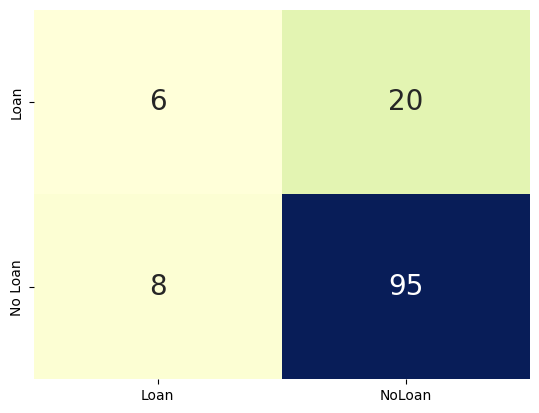

In [ ]:
cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Loan', 'NoLoan']
cr.index=['Loan', 'No Loan']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')

Changing the hyperparameter var_smoothing and choosing the values which gives the highest accuracy

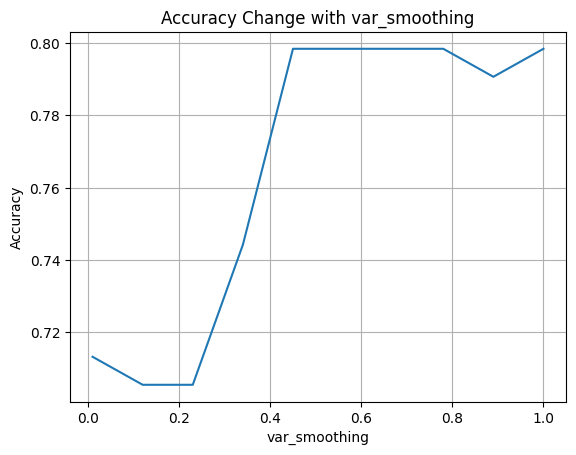

In [ ]:

# Define a range of var_smoothing values to explore
var_smoothing_values = np.linspace(0.01, 1.0, num=10)  # Adjust the range as needed

# Create an empty list to store accuracy values
accuracy_scores = []

# Iterate through var_smoothing values
for smoothing in var_smoothing_values:
    # Create a Gaussian Naive Bayes model with current smoothing parameter
    model = GaussianNB(var_smoothing=smoothing)

    # Train the model
    model.fit(x_train, y_train)

    # Make predictions on testing set
    y_pred = model.predict(x_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append accuracy to the list
    accuracy_scores.append(accuracy)

# Create the line chart
plt.plot(var_smoothing_values, accuracy_scores)
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')
plt.title('Accuracy Change with var_smoothing')
plt.grid(True)
plt.show()

Training Model with best value for var_smoothing

In [ ]:
model = GaussianNB(var_smoothing=0.6)
model.fit(x_train, y_train)

GaussianNB(var_smoothing=0.6)

Training Accuracy

In [ ]:
y_pred = model.predict(x_test)
model.score(x_train,y_train)

0.7150259067357513

Testing Accuracy

In [ ]:
print(accuracy_score(y_test, y_pred))

0.7984496124031008


Output Predicted Labels

In [ ]:
y_pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

Confusion Matrix

<Axes: >

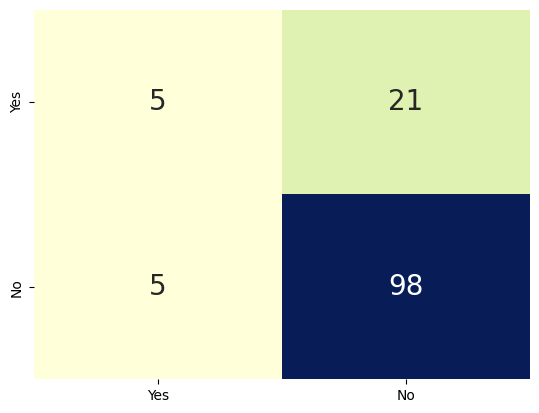

In [ ]:
cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')

MLP classifier


In [ ]:
activation_functions = ['identity', 'logistic', 'tanh']
accuracy_scores_identity = []
accuracy_scores_logistic = []
accuracy_scores_tanh = []

activation_functions = ['identity', 'logistic', 'tanh']

for k in activation_functions:
    for i in range(1, 100, 3):
        for l in np.arange(0.1, 1, 0.1):
            model = MLPClassifier(hidden_layer_sizes=i,
                                  activation=k,
                                  solver='sgd',  # Use SGD
                                  learning_rate='constant',
                                  learning_rate_init=l,
                                  max_iter=200)
            model.fit(x_train, y_train)

            # Make predictions on testing set
            y_pred = model.predict(x_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Append accuracy to the corresponding list based on activation function
            if k == 'identity':
                accuracy_scores_identity.append((accuracy, i, l))
            elif k == 'logistic':
                accuracy_scores_logistic.append((accuracy, i, l))
            elif k == 'tanh':
                accuracy_scores_tanh.append((accuracy, i, l))



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Plotting 3 graphs

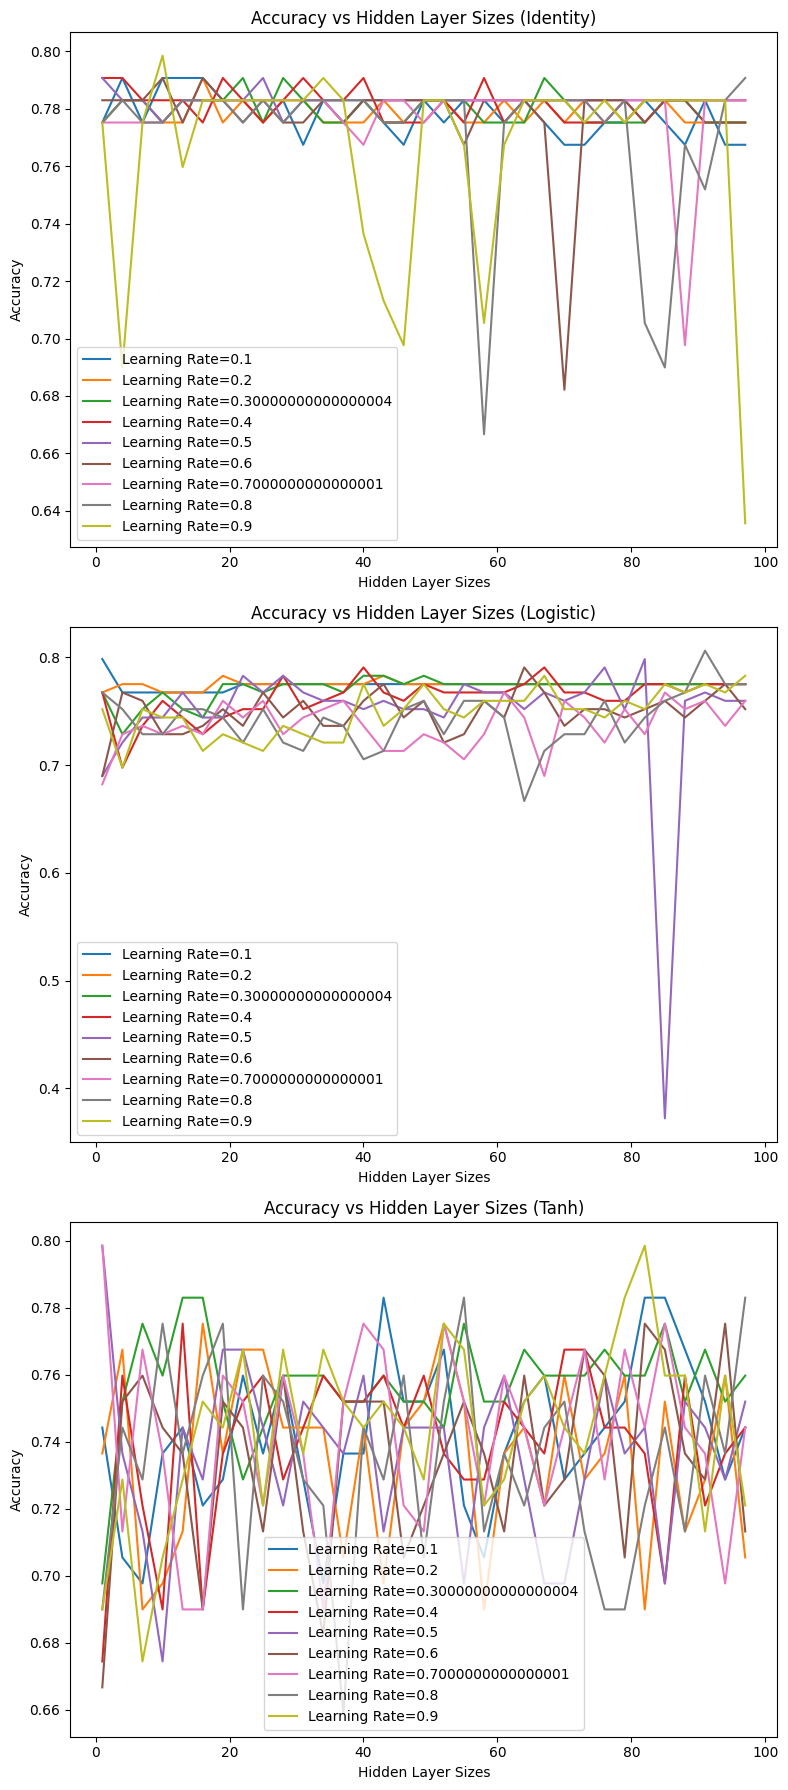

In [ ]:
plt.figure(figsize=(8, 18))

# Plot for identity activation function
plt.subplot(3, 1, 1)
for l in np.arange(0.1, 1, 0.1):
    accuracies = [acc[0] for acc in accuracy_scores_identity if acc[2] == l]
    hidden_sizes = [acc[1] for acc in accuracy_scores_identity if acc[2] == l]
    plt.plot(hidden_sizes, accuracies, label=f'Learning Rate={l}')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hidden Layer Sizes (Identity)')
plt.legend()

# Plot for logistic activation function
plt.subplot(3, 1, 2)
for l in np.arange(0.1, 1, 0.1):
    accuracies = [acc[0] for acc in accuracy_scores_logistic if acc[2] == l]
    hidden_sizes = [acc[1] for acc in accuracy_scores_logistic if acc[2] == l]
    plt.plot(hidden_sizes, accuracies, label=f'Learning Rate={l}')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hidden Layer Sizes (Logistic)')
plt.legend()

# Plot for tanh activation function
plt.subplot(3, 1, 3)
for l in np.arange(0.1, 1, 0.1):
    accuracies = [acc[0] for acc in accuracy_scores_tanh if acc[2] == l]
    hidden_sizes = [acc[1] for acc in accuracy_scores_tanh if acc[2] == l]
    plt.plot(hidden_sizes, accuracies, label=f'Learning Rate={l}')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hidden Layer Sizes (Tanh)')
plt.legend()

plt.tight_layout()
plt.show()

(0.7984496124031008, 82, 0.9)
(0.7984496124031008, 10, 0.9)
(0.8062015503875969, 91, 0.8)


<Axes: >

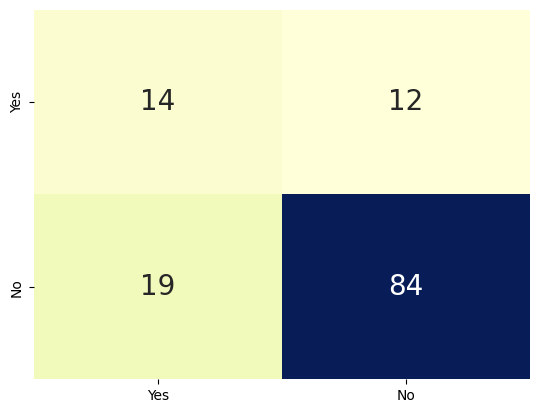

In [ ]:
print (max(accuracy_scores_tanh))
print (max(accuracy_scores_identity))
print (max(accuracy_scores_logistic))
model = MLPClassifier(hidden_layer_sizes=max(accuracy_scores_tanh)[1],
                                  activation='tanh',
                                  solver='sgd',  # Use SGD
                                  learning_rate='constant',
                                  learning_rate_init=max(accuracy_scores_tanh)[2],
                                  max_iter=200)
model.fit(x_train, y_train)

            # Make predictions on testing set
y_pred = model.predict(x_test)

cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: >

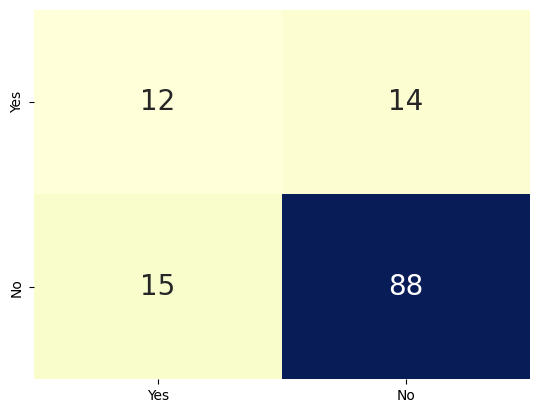

In [ ]:
model = MLPClassifier(hidden_layer_sizes=max(accuracy_scores_logistic)[1],
                                  activation='logistic',
                                  solver='sgd',  # Use SGD
                                  learning_rate='constant',
                                  learning_rate_init=max(accuracy_scores_logistic)[2],
                                  max_iter=200)
model.fit(x_train, y_train)

            # Make predictions on testing set
y_pred = model.predict(x_test)

cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')


<Axes: >

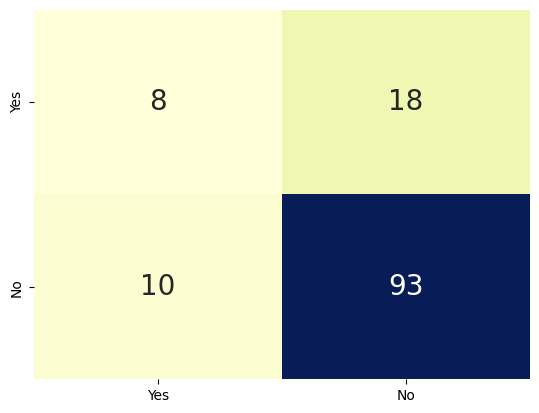

In [ ]:
model = MLPClassifier(hidden_layer_sizes=max(accuracy_scores_identity)[1],
                                  activation='identity',
                                  solver='sgd',  # Use SGD
                                  learning_rate='constant',
                                  learning_rate_init=max(accuracy_scores_identity)[2],
                                  max_iter=200)
model.fit(x_train, y_train)

            # Make predictions on testing set
y_pred = model.predict(x_test)

cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')


In [ ]:
accuracy_values=[]
max_dept_values=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for max_dept in max_dept_values:
    # Creating a decision tree classifier with specified max_depth
    clf = DecisionTreeClassifier(max_depth=max_dept,criterion='entropy')

    # Training the classifier on the training set
    clf.fit(x_train, y_train)

    # Making predictions on the testing set
    y_pred = clf.predict(x_test)

    # Calculating the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)


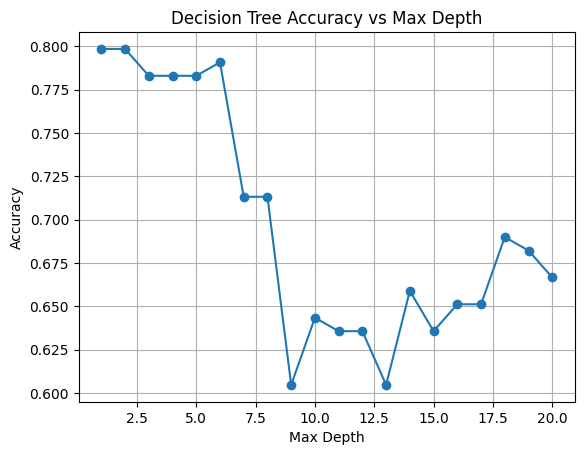

<Axes: >

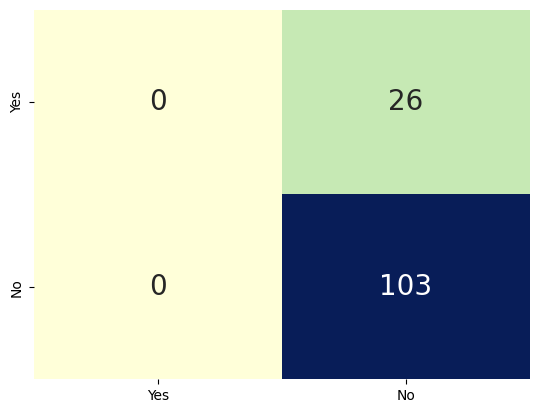

In [ ]:
plt.plot(max_dept_values, accuracy_values, marker='o')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
clf = DecisionTreeClassifier(max_depth=accuracy_values.index(max(accuracy_values))+1,criterion='entropy')

    # Training the classifier on the training set
clf.fit(x_train, y_train)

# Making predictions on the testing set
y_pred = clf.predict(x_test)
cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')

We used another value obtained from graph and trained the model. As the value of the

<Axes: >

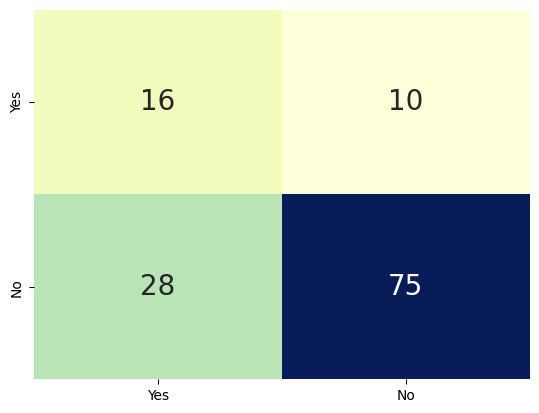

In [ ]:
clf = DecisionTreeClassifier(max_depth=7,criterion='entropy')

    # Training the classifier on the training set
clf.fit(x_train, y_train)

  # Making predictions on the testing set
y_pred = clf.predict(x_test)

cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')

In [ ]:
print(y_pred)

To overcome such problem we had to generate some data so that data becomes more balanced


We used SMOTE technique which generates data by drawing a line (or plane in higher dimensional data) between feature points and generates a new point on that line( or plane)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_resample , y_train_resample = smote.fit_resample(x_train, y_train)

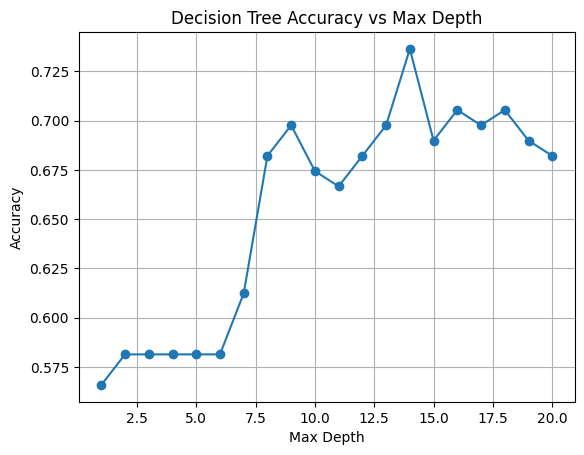

In [ ]:
plt.plot(max_dept_values, accuracy_values, marker='o')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:

accuracy_values=[]
max_dept_values=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for max_dept in max_dept_values:
    # Creating a decision tree classifier with specified max_depth
    clf = DecisionTreeClassifier(max_depth=max_dept,criterion='entropy')

    # Training the classifier on the training set
    clf.fit(x_train_resample, y_train_resample)

    # Making predictions on the testing set
    y_pred = clf.predict(x_test)

    # Calculating the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)


In [ ]:
print (accuracy_values)

[0.5658914728682171, 0.5813953488372093, 0.5813953488372093, 0.5813953488372093, 0.5813953488372093, 0.5813953488372093, 0.6124031007751938, 0.6821705426356589, 0.6976744186046512, 0.6744186046511628, 0.6666666666666666, 0.6821705426356589, 0.6976744186046512, 0.7364341085271318, 0.689922480620155, 0.7054263565891473, 0.6976744186046512, 0.7054263565891473, 0.689922480620155, 0.6821705426356589]


In [ ]:
print(y_pred)

<Axes: >

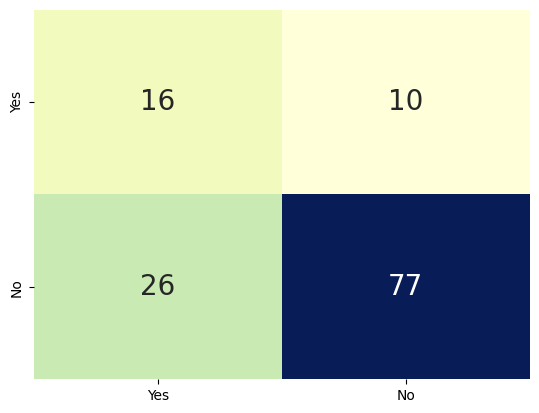

In [ ]:
clf = DecisionTreeClassifier(max_depth=accuracy_values.index(max(accuracy_values))+1,criterion='entropy')

    # Training the classifier on the training set
clf.fit(x_train_resample, y_train_resample)

# Making predictions on the testing set
y_pred = clf.predict(x_test)
cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')

In [ ]:
print(y_pred)

SVM


In [ ]:
from sklearn.svm import SVC
c_list=[]
c_list.append(0.1)
accuracy_values=[]
svm_model = SVC(C=0.1)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_values.append(accuracy)
for c in np.arange(0.5,1000,0.5):
  svm_model = SVC(C=c)
  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracy_values.append(accuracy)
  c_list.append(c)


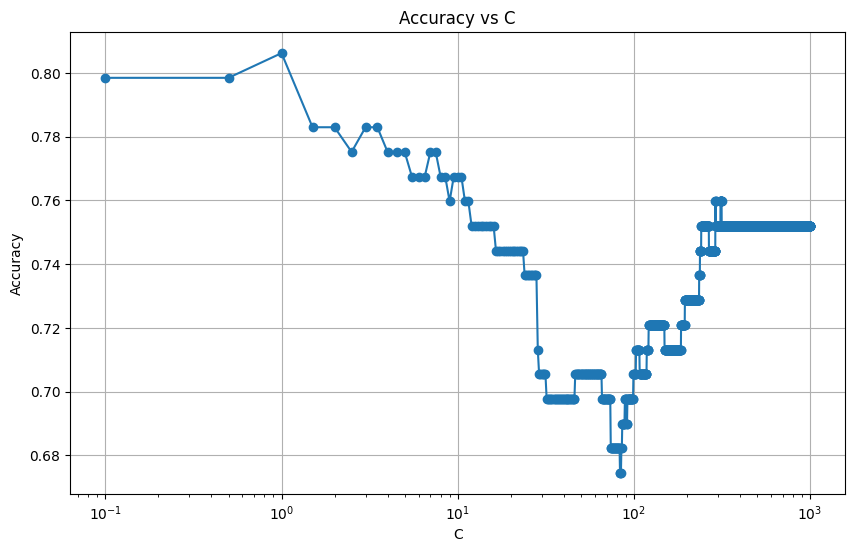

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(c_list, accuracy_values, marker='o', linestyle='-')
plt.title('Accuracy vs C')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale('log')  # Using a logarithmic scale for better visualization
plt.grid(True)
plt.show()

In [ ]:
best_c=accuracy_values.index(max(accuracy_values))/2
if (best_c == 0):
  best_c = 0.1


[1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1]


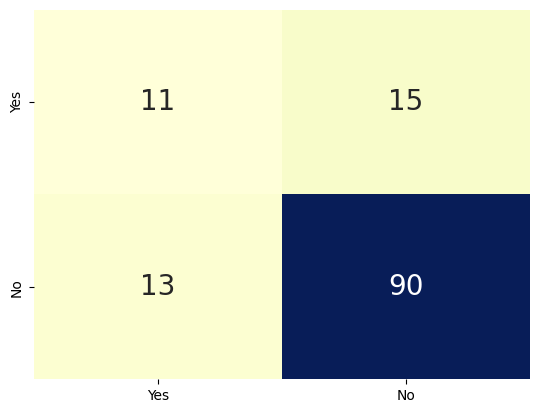

In [ ]:
svm_model = SVC(C=3)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
cr=confusion_matrix(y_test, y_pred)
cr=pd.DataFrame(cr)
cr.columns = ['Yes', 'No']
cr.index=['Yes', 'No']
sb.heatmap(cr, annot=True, annot_kws={"size": 20},cbar=0,xticklabels=True,yticklabels=1, fmt="d",cmap='YlGnBu')
print(y_pred)